##  Import related libraries

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

## Data preprocessing

In [2]:
csv_file='../input/breast-cancer-prediction-dataset/Breast_cancer_data.csv'
df=pd.read_csv(csv_file)
df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [3]:
df.dtypes

mean_radius        float64
mean_texture       float64
mean_perimeter     float64
mean_area          float64
mean_smoothness    float64
diagnosis            int64
dtype: object

In [4]:
df_corr=df.corr()

<AxesSubplot:>

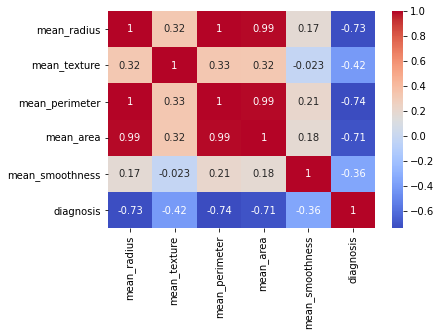

In [5]:
sns.heatmap(df_corr,annot=True,cmap='coolwarm')

In [6]:
# Dropping overlapped features
df.drop(['mean_radius','mean_area'],axis=1,inplace=True)

In [7]:
df_2_corr=df.corr()

<AxesSubplot:>

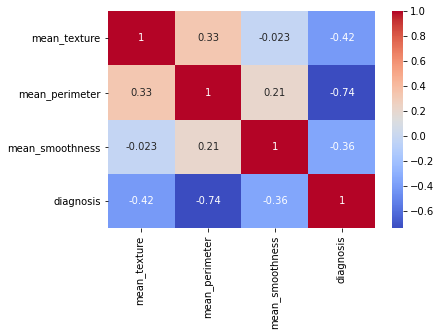

In [8]:
sns.heatmap(df_2_corr,annot=True,cmap='coolwarm')

In [9]:
df.diagnosis.value_counts()/len(df)

1    0.627417
0    0.372583
Name: diagnosis, dtype: float64

<AxesSubplot:xlabel='count', ylabel='diagnosis'>

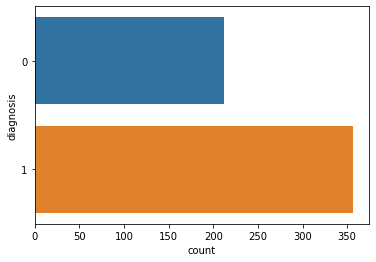

In [10]:
sns.countplot(y=df.diagnosis)

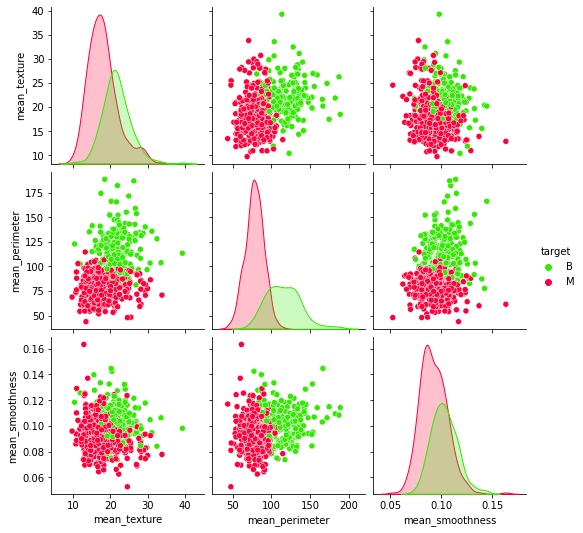

In [11]:
df['target'] = df['diagnosis'].map({0:'B',1:'M'})
sns.pairplot(df.drop('diagnosis', axis = 1), hue='target',palette='prism');

In [12]:
X = df.drop(['diagnosis','target'],axis=1)
Y = df['diagnosis']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [14]:
x_train

,mean_texture,mean_perimeter,mean_smoothness
338,17.53,64.41,0.10070
427,21.98,68.79,0.08801
406,14.86,104.30,0.09495
96,17.84,77.79,0.10450
490,22.44,78.18,0.08192
...,...,...,...
277,19.98,120.90,0.08923
9,24.04,83.97,0.11860
359,18.32,59.82,0.10090
192,18.22,60.73,0.06950


In [15]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X_train = sc.fit_transform(x_train)
y_train=np.array(y_train)
X_test = sc.fit_transform(x_test)
y_test=np.array(y_test)

## Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

log_clf=LogisticRegression()

In [17]:
log_clf.fit(X_train,y_train)

LogisticRegression()

In [18]:
y_pred=log_clf.predict(X_test)

In [19]:
log_clf.score(X_test,y_test)

0.9122807017543859

In [20]:
log_clf.score(X_train,y_train)

0.9186813186813186

## SVC

In [21]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
grid=GridSearchCV(SVC(),param_grid)

In [22]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [23]:
grid.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [24]:
svc=SVC(**grid.best_params_)

In [25]:
svc.fit(X_train,y_train)

SVC(C=100, gamma=0.1)

In [26]:
svc.score(X_train,y_train)

0.9406593406593406

In [27]:
svc.score(X_test,y_test)

0.9298245614035088

In [28]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
y_pred=svc.predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred)
cm_svc

array([[41,  6],
       [ 2, 65]])

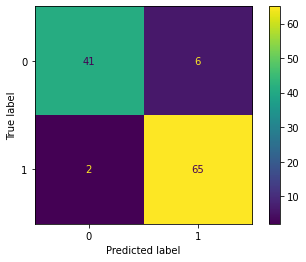

In [29]:
plot_confusion_matrix(svc,X_test,y_test)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91        47
           1       0.92      0.97      0.94        67

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114



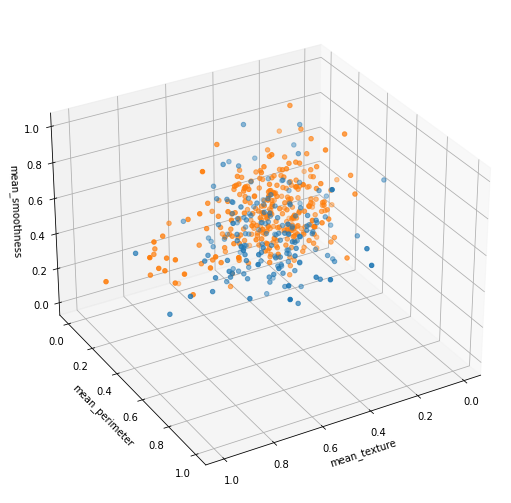

In [31]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fig.set_size_inches(9, 9)
tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0][y_train==0], X_train[:,1][y_train==0],X_train[:,2][y_train==0],'ob')
ax.scatter(X_train[:,0][y_train==1], X_train[:,1][y_train==1],X_train[:,2][y_train==1],'sr')
ax.set_xlabel(f"{x_train.columns[0]}")
ax.set_ylabel(f"{x_train.columns[1]}")
ax.set_zlabel(f"{x_train.columns[2]}")
ax.view_init(30, 60)
plt.show()

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()

In [33]:
param_grid = { 
    'n_estimators': [50,100,200,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [34]:
grid_rf=GridSearchCV(rf,param_grid)

In [35]:
grid_rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 500]})

In [36]:
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 50}

In [37]:
rf=RandomForestClassifier(**grid_rf.best_params_)

In [38]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=50)

In [39]:
rf.score(X_train,y_train)

0.9978021978021978

In [40]:
rf.score(X_test,y_test)

0.9122807017543859

In [41]:
y_pred=rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred)
cm_rf

array([[45,  2],
       [ 8, 59]])

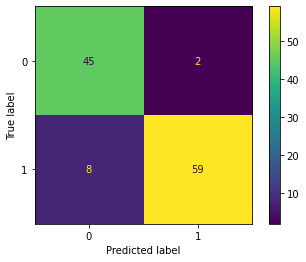

In [42]:
plot_confusion_matrix(rf,X_test,y_test)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        47
           1       0.97      0.88      0.92        67

    accuracy                           0.91       114
   macro avg       0.91      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



## GradientBoostingClassifier

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

GBC=GradientBoostingClassifier()

In [45]:
GBC.fit(X_train,y_train)

GradientBoostingClassifier()

In [46]:
GBC.score(X_train,y_train)

0.9978021978021978

In [47]:
GBC.score(X_test,y_test)

0.9298245614035088

## HistGradientBoostingClassifier

In [48]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
HGBC=HistGradientBoostingClassifier()

In [49]:
HGBC.fit(X_train,y_train)

HistGradientBoostingClassifier()

In [50]:
HGBC.score(X_train,y_train)

1.0

In [51]:
HGBC.score(X_test,y_test)

0.9122807017543859

## Voting

In [52]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

eclf = VotingClassifier(
    estimators=[('svc', svc), ('rf', rf), ('GBC', GBC),('HGBC',HGBC)],
    voting='hard')

for clf_num, label in zip([svc, rf, GBC , HGBC], ['Support Vector Machine', 'Random Forest', 'GBC', 'HGBC']):
    scores = cross_val_score(clf_num, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.94 (+/- 0.03) [Support Vector Machine]
Accuracy: 0.92 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.03) [GBC]
Accuracy: 0.91 (+/- 0.01) [HGBC]


In [53]:
eclf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc', SVC(C=100, gamma=0.1)),
                             ('rf',
                              RandomForestClassifier(max_depth=8,
                                                     max_features='log2',
                                                     n_estimators=50)),
                             ('GBC', GradientBoostingClassifier()),
                             ('HGBC', HistGradientBoostingClassifier())])

In [54]:
eclf.score(X_train,y_train)

0.9978021978021978

In [55]:
eclf.score(X_test,y_test)

0.9210526315789473

In [56]:
y_pred=eclf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred)
cm_rf

array([[44,  3],
       [ 6, 61]])

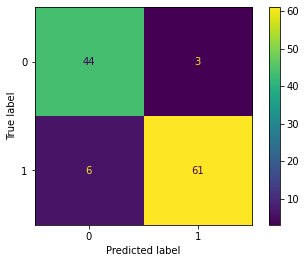

In [57]:
plot_confusion_matrix(eclf,X_test,y_test)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        47
           1       0.95      0.91      0.93        67

    accuracy                           0.92       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



## Deep learning

In [59]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(20,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [60]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [61]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=300)

Epoch 1/300
15/15 [==============================] - 1s 46ms/step - loss: 0.6968 - accuracy: 0.3820 - val_loss: 0.6823 - val_accuracy: 0.7281
Epoch 2/300
15/15 [==============================] - 0s 6ms/step - loss: 0.6821 - accuracy: 0.7103 - val_loss: 0.6758 - val_accuracy: 0.5965
Epoch 3/300
15/15 [==============================] - 0s 6ms/step - loss: 0.6685 - accuracy: 0.6555 - val_loss: 0.6691 - val_accuracy: 0.5877
Epoch 4/300
15/15 [==============================] - 0s 6ms/step - loss: 0.6647 - accuracy: 0.6218 - val_loss: 0.6600 - val_accuracy: 0.5877
Epoch 5/300
15/15 [==============================] - 0s 6ms/step - loss: 0.6491 - accuracy: 0.6531 - val_loss: 0.6508 - val_accuracy: 0.5965
Epoch 6/300
15/15 [==============================] - 0s 6ms/step - loss: 0.6394 - accuracy: 0.6495 - val_loss: 0.6409 - val_accuracy: 0.6053
Epoch 7/300
15/15 [==============================] - 0s 5ms/step - loss: 0.6355 - accuracy: 0.6402 - val_loss: 0.6283 - val_accuracy: 0.7105
Epoch 8/300


Text(0.5, 1.0, 'Training and validation loss')

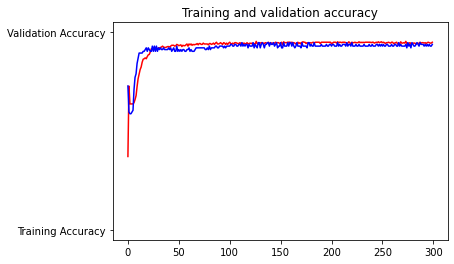

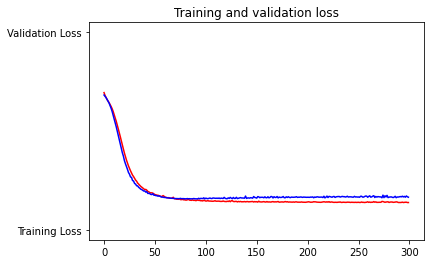

In [62]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [63]:
y_prediction=model.predict(X_test)
cutoff=0.5
y_pred=np.where(y_prediction>cutoff,1,0)

In [64]:
cm_deep = confusion_matrix(y_test, y_pred)
cm_deep

array([[42,  5],
       [ 2, 65]])

<AxesSubplot:>

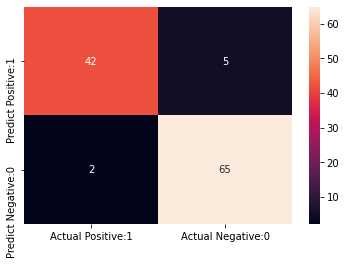

In [65]:
cm_matrix = pd.DataFrame(data=cm_deep, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True)

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92        47
           1       0.93      0.97      0.95        67

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114



## Conclusion: I have tried 7 different models to train (linear, svc, random forest, gradientboosting, histgradientboosting, voting with 3 tree based & svc and deep learning), and voting method and deep learning have the best score. However, while voting model has more false negative, deep learning has more false positive and since false negative could bring more critical issues in breast cancer classification, deep learning algorithm shows the best result.